In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize, least_squares
from scipy.stats import kendalltau 
from scipy.integrate import odeint
from scipy.ndimage import gaussian_filter
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.feature_selection import SelectKBest, f_regression, f_classif
import statsmodels.formula.api as sm
from statsmodels.formula.api import ols
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import tensorflow.keras.backend as K
from sklearn.impute import SimpleImputer
import tensorflow.keras.backend as K
import folium
from folium.plugins import HeatMap
import geopandas as gpd
import random
from datetime import datetime, timedelta
from tqdm import tqdm
from matplotlib.animation import FuncAnimation
from shapely.geometry import Point
from dowhy import CausalModel

In [2]:
def generate_climate_migration_data(num_records=5000, num_years=10, start_year=2014):
    
    
    # Provinces and their base characteristics
    provinces = [
        'Kwazulu Natal', 'Eastern Cape', 'Western Cape', 'Northern Cape',
        'Free State', 'North West', 'Limpopo', 'Gauteng', 'Mpumalanga'
    ]
    
    # Comprehensive province data dictionary
    province_data = {
        'Kwazulu Natal': {
            'population': 12423907,
            'land_area': 94361,
            'education_facilities': 75,
            'employment_opportunities': 80,
            'agriculture': {'farming_intensity': 0.8, 'crop_diversity': 0.75, 'irrigation_access': 0.7},
            'business': {'economic_diversity': 0.75, 'infrastructure': 0.7, 'market_access': 0.8},
            'social': {'baseline_stability': 0.7, 'service_delivery': 0.65, 'social_cohesion': 0.7}
        },
        'Eastern Cape': {
            'population': 7423907,
            'land_area': 168966,
            'education_facilities': 60,
            'employment_opportunities': 60,
            'agriculture': {'farming_intensity': 0.6, 'crop_diversity': 0.65, 'irrigation_access': 0.5},
            'business': {'economic_diversity': 0.6, 'infrastructure': 0.55, 'market_access': 0.65},
            'social': {'baseline_stability': 0.6, 'service_delivery': 0.55, 'social_cohesion': 0.65}
        },
        'Western Cape': {
            'population': 7433020,
            'land_area': 129462,
            'education_facilities': 85,
            'employment_opportunities': 90,
            'agriculture': {'farming_intensity': 0.85, 'crop_diversity': 0.9, 'irrigation_access': 0.85},
            'business': {'economic_diversity': 0.9, 'infrastructure': 0.85, 'market_access': 0.9},
            'social': {'baseline_stability': 0.85, 'service_delivery': 0.8, 'social_cohesion': 0.75}
        },
        'Northern Cape': {
            'population': 1355945,
            'land_area': 372889,
            'education_facilities': 40,
            'employment_opportunities': 50,
            'agriculture': {'farming_intensity': 0.4, 'crop_diversity': 0.45, 'irrigation_access': 0.6},
            'business': {'economic_diversity': 0.45, 'infrastructure': 0.5, 'market_access': 0.4},
            'social': {'baseline_stability': 0.75, 'service_delivery': 0.6, 'social_cohesion': 0.8}
        },
        'Free State': {
            'population': 2964412,
            'land_area': 129825,
            'education_facilities': 55,
            'employment_opportunities': 65,
            'agriculture': {'farming_intensity': 0.9, 'crop_diversity': 0.7, 'irrigation_access': 0.75},
            'business': {'economic_diversity': 0.65, 'infrastructure': 0.6, 'market_access': 0.7},
            'social': {'baseline_stability': 0.65, 'service_delivery': 0.6, 'social_cohesion': 0.7}
        },
        'North West': {
            'population': 3804548,
            'land_area': 104882,
            'education_facilities': 50,
            'employment_opportunities': 70,
            'agriculture': {'farming_intensity': 0.75, 'crop_diversity': 0.6, 'irrigation_access': 0.65},
            'business': {'economic_diversity': 0.55, 'infrastructure': 0.6, 'market_access': 0.65},
            'social': {'baseline_stability': 0.6, 'service_delivery': 0.55, 'social_cohesion': 0.65}
        },
        'Limpopo': {
            'population': 6572721,
            'land_area': 125754,
            'education_facilities': 45,
            'employment_opportunities': 55,
            'agriculture': {'farming_intensity': 0.7, 'crop_diversity': 0.8, 'irrigation_access': 0.6},
            'business': {'economic_diversity': 0.5, 'infrastructure': 0.55, 'market_access': 0.6},
            'social': {'baseline_stability': 0.65, 'service_delivery': 0.6, 'social_cohesion': 0.75}
        },
        'Gauteng': {
            'population': 15099422,
            'land_area': 18176,
            'education_facilities': 100,
            'employment_opportunities': 100,
            'agriculture': {'farming_intensity': 0.3, 'crop_diversity': 0.4, 'irrigation_access': 0.8},
            'business': {'economic_diversity': 0.95, 'infrastructure': 0.9, 'market_access': 0.95},
            'social': {'baseline_stability': 0.75, 'service_delivery': 0.75, 'social_cohesion': 0.65}
        },
        'Mpumalanga': {
            'population': 5143324,
            'land_area': 76495,
            'education_facilities': 48,
            'employment_opportunities': 65,
            'agriculture': {'farming_intensity': 0.85, 'crop_diversity': 0.75, 'irrigation_access': 0.7},
            'business': {'economic_diversity': 0.7, 'infrastructure': 0.65, 'market_access': 0.75},
            'social': {'baseline_stability': 0.65, 'service_delivery': 0.6, 'social_cohesion': 0.7}
        }
    }
    
    # Generate Date and Related Columns
    dates = pd.date_range(start=f'{start_year}-01-01', end=f'{start_year + num_years - 1}-12-31', freq='ME')
    seasonal_variation = np.sin((dates.month - 1) * (2 * np.pi / 12))
    
    data_list = []
    records_per_province = num_records // len(provinces)

    for province in provinces:
        base_population = province_data[province]['population']
        area = province_data[province]['land_area']
        education_factor = province_data[province]['education_facilities'] / 100
        employment_factor = province_data[province]['employment_opportunities'] / 100
        
        for i in range(records_per_province):
            date = dates[i % len(dates)]
            years_since_start = date.year - start_year
            
            # Population and density calculations
            random_annual_growth_rate = np.random.uniform(0.01, 0.02)
            population = int(base_population * (1 + random_annual_growth_rate) ** years_since_start)
            population_density = population / area
            
            # Climate variables
            long_term_temp_rise = 0.02 * years_since_start
            avg_temp = 20 + 10 * seasonal_variation[i % len(seasonal_variation)] + long_term_temp_rise + np.random.normal(0, 0.5)
            avg_precipitation = 50 + 20 * seasonal_variation[i % len(seasonal_variation)] + np.random.normal(0, 10)
            heatwave_days = max(0, int(5 * seasonal_variation[i % len(seasonal_variation)] + np.random.poisson(2) * (avg_temp / 25)))
            
            # Environmental indicators
            co2_levels = 400 + 2.5 * years_since_start + np.random.normal(0, 1.5) + (population / 1e6)
            avg_temperature_trend = 15 + long_term_temp_rise + (co2_levels - 400) * 0.01 + np.random.normal(0, 0.5)
            drought_frequency = max(0, int(seasonal_variation[i % len(seasonal_variation)] * 2 + np.random.poisson(1) - avg_precipitation / 50))
            flood_events = max(0, int(seasonal_variation[i % len(seasonal_variation)] * 2 + np.random.poisson(2) * (avg_precipitation / 100)))
            
            # Economic and social metrics
            economic_inequality = np.random.uniform(0, 1)
            agri_chars = province_data[province]['agriculture']
            bus_env = province_data[province]['business']
            soc_stab = province_data[province]['social']
            
            # Agricultural metrics
            rainfall_adequacy = avg_precipitation / 50
            crop_yield = agri_chars['farming_intensity'] * (0.7 + 0.3 * rainfall_adequacy) * (1 - 0.1 * max(0, heatwave_days)) * np.random.uniform(0.8, 1.2)
            livestock_health = max(0, min(1, 0.8 + 0.2 * rainfall_adequacy - 0.1 * heatwave_days / 30)) * np.random.uniform(0.9, 1.1)
            agri_productivity_changes = np.random.uniform(-5, 5) + (avg_precipitation / 100) - (avg_temp / 100)
            
            # Business and economic metrics
            new_businesses = int(base_population / 1000 * bus_env['economic_diversity'] * (1 - economic_inequality / 2) * np.random.uniform(0.8, 1.2))
            market_performance = bus_env['market_access'] * (1 - economic_inequality / 2) * np.random.uniform(0.8, 1.2)
            job_losses = np.random.randint(0, 500) + int(population / 100000)
            healthcare_costs = np.random.normal(200000, 50000) + (population_density * 100) + (heatwave_days * 1000)
            renewable_energy_investments = 200000 + flood_events * 10000 + (co2_levels - 400) * 200
            tourism_economic_losses = np.random.uniform(10000, 100000) * (1 + flood_events / 10)
            
            # Social metrics
            extreme_weather_events = np.random.poisson(1 + heatwave_days / 10)
            disaster_recovery_costs = np.random.normal(500000, 100000) + (extreme_weather_events * 50000)
            protest_events = int(base_population / 100000 * (1 - soc_stab['service_delivery']) * (1 + job_losses/population) * np.random.uniform(0.8, 1.2))
            social_tension_index = max(0, min(1, (1 - soc_stab['social_cohesion']) * (1 + economic_inequality) * (1 + job_losses/population))) * np.random.uniform(0.9, 1.1)
            
            # Migration calculations
            inflow = np.random.randint(100, 500) + int(50 * (1 - population_density / 1000))
            outflow = np.random.randint(50, 450) - int(30 * (population_density / 1000))
            net_migration = inflow - outflow
            growth_rate = (net_migration / population) * 100
            
            # Enhanced migration features
            season = (date.month % 12 + 3) // 3
            labor_migration = int(job_losses * (1 - employment_factor) * (economic_inequality * 2) * np.random.uniform(0.8, 1.2))
            forced_migration = int((extreme_weather_events * 100 + disaster_recovery_costs / 10000) * np.random.uniform(0.7, 1.3))
            env_migration = int((drought_frequency * 150 + flood_events * 200 + heatwave_days * 50) * np.random.uniform(0.8, 1.2))
            edu_migration = int(base_population * 0.001 * education_factor * np.random.uniform(0.8, 1.2))
            seasonal_migration = int(1000 * (1 + seasonal_variation[i % len(seasonal_variation)]) * agri_productivity_changes / 100 * np.random.uniform(0.8, 1.2))
            
            # Urban-Rural population split
            urban_pop = int(population * np.random.uniform(0.6, 0.9))
            rural_pop = population - urban_pop
            
            # Compile all data
            record = {
                "Date": date,
                "Year": date.year,
                "Month": date.month,
                "Province": province,
                "Population": population,
                "Urban_Population": urban_pop,
                "Rural_Population": rural_pop,
                "Population_Density": population_density,
                "Average_Temperature": avg_temp,
                "Average_Precipitation": avg_precipitation,
                "Heatwave_Days": heatwave_days,
                "CO2_Levels": co2_levels,
                "Average_Temperature_Trend": avg_temperature_trend,
                "Drought_Frequency": drought_frequency,
                "Flood_Events": flood_events,
                "Crop_Yield": crop_yield,
                "Livestock_Health": livestock_health,
                "Agricultural_Productivity_Changes": agri_productivity_changes,
                "New_Businesses": new_businesses,
                "Market_Performance": market_performance,
                "Job_Losses": job_losses,
                "Healthcare_Costs": healthcare_costs,
                "Renewable_Energy_Investments": renewable_energy_investments,
                "Tourism_Economic_Losses": tourism_economic_losses,
                "Extreme_Weather_Events": extreme_weather_events,
                "Disaster_Recovery_Costs": disaster_recovery_costs,
                "Protest_Events": protest_events,
                "Social_Tension_Index": social_tension_index,
                "Economic_Inequality": economic_inequality,
                "Inflow": inflow,
                "Outflow": outflow,
                "Net_Migration": net_migration,
                "Growth_Rate": growth_rate,
                "Labor_Migration": labor_migration,
                "Forced_Migration": forced_migration,
                "Environmental_Migration": env_migration,
                "Educational_Migration": edu_migration,
                "Seasonal_Migration": seasonal_migration,
               "Urban_Rural_Ratio": urban_pop / rural_pop if rural_pop > 0 else np.inf,
                "Permanent_Migration": int(net_migration * 0.4),
                "Temporary_Migration": int(net_migration * 0.6),
                "Circular_Migration": int(seasonal_migration * 0.7 * np.random.uniform(0.8, 1.2)),
                "Family_Reunification": int(net_migration * 0.2 * np.random.uniform(0.8, 1.2)),
                "Migration_Patterns": 'High Inflow' if net_migration > 200 else 'High Outflow' if net_migration < -200 else 'Balanced',
                "Season": season,
                "Season_Name": {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}[season],
                "Land_Area": area,
                "Education_Factor": education_factor,
                "Employment_Factor": employment_factor,
                "Farming_Intensity": agri_chars['farming_intensity'],
                "Crop_Diversity": agri_chars['crop_diversity'],
                "Irrigation_Access": agri_chars['irrigation_access'],
                "Economic_Diversity": bus_env['economic_diversity'],
                "Infrastructure": bus_env['infrastructure'],
                "Market_Access": bus_env['market_access'],
                "Baseline_Stability": soc_stab['baseline_stability'],
                "Service_Delivery": soc_stab['service_delivery'],
                "Social_Cohesion": soc_stab['social_cohesion']
            }
            
            data_list.append(record)

    # Create DataFrame and add Year_Month column
    df = pd.DataFrame(data_list)
    df['Year_Month'] = df['Year'].astype(str) + '-' + df['Month'].astype(str).str.zfill(2)
    
    return df


if __name__ == "__main__":
    df = generate_climate_migration_data()
    df.to_csv("climate_migration_comprehensive_data.csv", index=False)
    print(f"Generated {len(df)} records with {len(df.columns)} features")


Generated 4995 records with 59 features


In [3]:
df.head(10)

def basic_data_analysis(df):
    """Perform basic data analysis and print summary statistics"""
    print("\n=== Basic Data Analysis ===")
    print("\nDataset Info:")
    print(df.info())
    
    print("\nNumerical Columns Summary Statistics:")
    print(df.describe())
    
    print("\nMissing Values Analysis:")
    missing_values = df.isnull().sum()
    print(missing_values[missing_values > 0])

def analyze_migration_patterns(df):
    """Analyze migration patterns across provinces"""
    print("\n=== Migration Patterns Analysis ===")
    
    # Calculate average migration metrics by province
    migration_metrics = df.groupby('Province').agg({
        'Net_Migration': 'mean',
        'Environmental_Migration': 'mean',
        'Labor_Migration': 'mean',
        'Educational_Migration': 'mean'
    }).round(2)
    
    print("\nAverage Migration Metrics by Province:")
    print(migration_metrics)

def analyze_environmental_factors(df):
    """Analyze environmental factors and their relationships"""
    print("\n=== Environmental Factors Analysis ===")
    
    # Calculate correlations between environmental variables
    env_vars = ['Average_Temperature', 'Average_Precipitation', 'CO2_Levels', 
                'Drought_Frequency', 'Flood_Events', 'Extreme_Weather_Events']
    
    env_corr = df[env_vars].corr()
    print("\nEnvironmental Factors Correlation:")
    print(env_corr.round(2))

def analyze_socioeconomic_impact(df):
    """Analyze socioeconomic impacts and relationships"""
    print("\n=== Socioeconomic Impact Analysis ===")
    
    # Calculate average socioeconomic metrics by province
    socio_metrics = df.groupby('Province').agg({
        'Economic_Inequality': 'mean',
        'Job_Losses': 'mean',
        'Social_Tension_Index': 'mean',
        'Protest_Events': 'mean'
    }).round(2)
    
    print("\nAverage Socioeconomic Metrics by Province:")
    print(socio_metrics)

def seasonal_analysis(df):
    """Analyze seasonal patterns in migration and environmental factors"""
    print("\n=== Seasonal Analysis ===")
    
    # Calculate seasonal averages
    seasonal_metrics = df.groupby('Season_Name').agg({
        'Net_Migration': 'mean',
        'Environmental_Migration': 'mean',
        'Average_Temperature': 'mean',
        'Average_Precipitation': 'mean'
    }).round(2)
    
    print("\nSeasonal Averages:")
    print(seasonal_metrics)

def analyze_migration_drivers(df):
    """Analyze factors driving migration patterns"""
    print("\n=== Migration Drivers Analysis ===")
    
    # Calculate correlations with migration
    migration_vars = ['Net_Migration', 'Average_Temperature', 'Average_Precipitation',
                     'Economic_Inequality', 'Job_Losses', 'Social_Tension_Index',
                     'Extreme_Weather_Events']
    
    migration_corr = df[migration_vars].corr()['Net_Migration'].sort_values(ascending=False)
    print("\nFactors Correlated with Net Migration:")
    print(migration_corr)

def analyze_urban_rural_dynamics(df):
    """Analyze urban-rural population dynamics"""
    print("\n=== Urban-Rural Dynamics Analysis ===")
    
    # Calculate urban-rural ratios
    urban_rural_metrics = df.groupby('Province').agg({
        'Urban_Population': 'mean',
        'Rural_Population': 'mean',
        'Urban_Rural_Ratio': 'mean'
    }).round(2)
    
    print("\nUrban-Rural Population Metrics by Province:")
    print(urban_rural_metrics)

def main():
    
    # Run all analyses
    basic_data_analysis(df)
    analyze_migration_patterns(df)
    analyze_environmental_factors(df)
    analyze_socioeconomic_impact(df)
    seasonal_analysis(df)
    analyze_migration_drivers(df)
    analyze_urban_rural_dynamics(df)
    # Replace NaN with 0
    df.fillna(0, inplace=True)
    
    print("\nEDA completed successfully!")

if __name__ == "__main__":
    main()


=== Basic Data Analysis ===

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4995 entries, 0 to 4994
Data columns (total 59 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Date                               4995 non-null   datetime64[ns]
 1   Year                               4995 non-null   int64         
 2   Month                              4995 non-null   int64         
 3   Province                           4995 non-null   object        
 4   Population                         4995 non-null   int64         
 5   Urban_Population                   4995 non-null   int64         
 6   Rural_Population                   4995 non-null   int64         
 7   Population_Density                 4995 non-null   float64       
 8   Average_Temperature                4995 non-null   float64       
 9   Average_Precipitation              4995 non-null   float64     

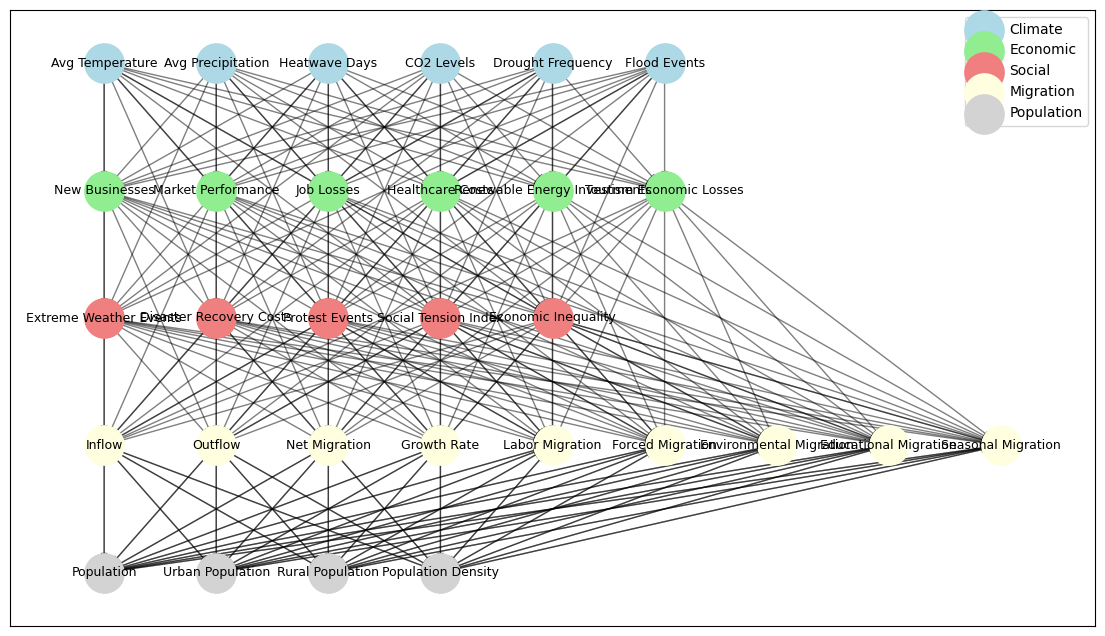

In [4]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Define groups of variables with all nodes included
groups = {
    "Climate": [
        "Avg Temperature", "Avg Precipitation", "Heatwave Days",
        "CO2 Levels", "Drought Frequency", "Flood Events"
    ],
    "Economic": [
        "New Businesses", "Market Performance", "Job Losses",
        "Healthcare Costs", "Renewable Energy Investments", "Tourism Economic Losses"
    ],
    "Social": [
        "Extreme Weather Events", "Disaster Recovery Costs", 
        "Protest Events", "Social Tension Index", "Economic Inequality"
    ],
    "Migration": [
        "Inflow", "Outflow", "Net Migration", "Growth Rate",
        "Labor Migration", "Forced Migration", "Environmental Migration",
        "Educational Migration", "Seasonal Migration"
    ],
    "Population": [
        "Population", "Urban Population", "Rural Population", "Population Density"
    ]
}

# Add nodes for each variable
for group, vars in groups.items():
    G.add_nodes_from(vars)

# Add edges to represent causal relationships
# Climate to Economic
for c in groups["Climate"]:
    for e in groups["Economic"]:
        G.add_edge(c, e)

# Climate to Social
for c in groups["Climate"]:
    for s in groups["Social"]:
        G.add_edge(c, s)

# Economic to Migration
for e in groups["Economic"]:
    for m in groups["Migration"]:
        G.add_edge(e, m)

# Social to Migration
for s in groups["Social"]:
    for m in groups["Migration"]:
        G.add_edge(s, m)

# Population to Migration
for p in groups["Population"]:
    for m in groups["Migration"]:
        G.add_edge(p, m)

# Migration to Population
for m in groups["Migration"]:
    for p in groups["Population"]:
        G.add_edge(m, p)

# Define positions for each group manually to avoid overlap
pos = {
    # Climate variables
    "Avg Temperature": (0, 5),
    "Avg Precipitation": (1, 5),
    "Heatwave Days": (2, 5),
    "CO2 Levels": (3, 5),
    "Drought Frequency": (4, 5),
    "Flood Events": (5, 5),

    # Economic variables
    "New Businesses": (0, 3),
    "Market Performance": (1, 3),
    "Job Losses": (2, 3),
    "Healthcare Costs": (3, 3),
    "Renewable Energy Investments": (4, 3),
    "Tourism Economic Losses": (5, 3),

    # Social variables
    "Extreme Weather Events": (0, 1),
    "Disaster Recovery Costs": (1, 1),
    "Protest Events": (2, 1),
    "Social Tension Index": (3, 1),
    "Economic Inequality": (4, 1),

    # Migration variables
    "Inflow": (0, -1),
    "Outflow": (1, -1),
    "Net Migration": (2, -1),
    "Growth Rate": (3, -1),
    "Labor Migration": (4, -1),
    "Forced Migration": (5, -1),
    "Environmental Migration": (6, -1),
    "Educational Migration": (7, -1),
    "Seasonal Migration": (8, -1),

    # Population variables
    "Population": (0, -3),
    "Urban Population": (1, -3),
    "Rural Population": (2, -3),
    "Population Density": (3, -3)
}

# Draw the graph
plt.figure(figsize=(14, 8))

# Draw nodes and edges
colors = {
    "Climate": "lightblue",
    "Economic": "lightgreen",
    "Social": "lightcoral",
    "Migration": "lightyellow",
    "Population": "lightgrey"
}

# Draw nodes with colors based on their group
for group, vars in groups.items():
    nx.draw_networkx_nodes(G, pos, nodelist=vars, node_color=colors[group], label=group, node_size=800)

nx.draw_networkx_edges(G, pos, arrows=True, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=9)

# Add legend and title
plt.legend(scatterpoints=1)

In [5]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

# Load the generated data
df = pd.read_csv("climate_migration_comprehensive_data.csv")

# Select relevant variables for Granger causality
# For example, we can test if 'Average_Temperature' Granger-causes 'Net_Migration'
data = df[['Average_Temperature', 'Net_Migration']]

# Perform Granger Causality test
max_lag = 5  # You can adjust the max lag as needed
results = grangercausalitytests(data, max_lag, verbose=True)

# Display results for the first lag
for key in results:
    print(f"Lag {key}:")
    print(f"F-statistic: {results[key][0]['ssr_ftest'][0]}")
    print(f"P-value: {results[key][0]['ssr_ftest'][1]}")


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0468  , p=0.1526  , df_denom=4991, df_num=1
ssr based chi2 test:   chi2=2.0480  , p=0.1524  , df=1
likelihood ratio test: chi2=2.0476  , p=0.1524  , df=1
parameter F test:         F=2.0468  , p=0.1526  , df_denom=4991, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.3744  , p=0.0343  , df_denom=4988, df_num=2
ssr based chi2 test:   chi2=6.7555  , p=0.0341  , df=2
likelihood ratio test: chi2=6.7509  , p=0.0342  , df=2
parameter F test:         F=3.3744  , p=0.0343  , df_denom=4988, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1805  , p=0.0882  , df_denom=4985, df_num=3
ssr based chi2 test:   chi2=6.5508  , p=0.0877  , df=3
likelihood ratio test: chi2=6.5465  , p=0.0878  , df=3
parameter F test:         F=2.1805  , p=0.0882  , df_denom=4985, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2571  , p=0.

C:\Users\tyeba\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [6]:
import statsmodels.api as sm

# Define the dependent and independent variables
X = df[['Average_Temperature', 'Average_Precipitation', 'Population_Density']]
y = df['Net_Migration']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Net_Migration   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.185
Date:                Fri, 29 Nov 2024   Prob (F-statistic):             0.0228
Time:                        09:13:16   Log-Likelihood:                -32623.
No. Observations:                4995   AIC:                         6.525e+04
Df Residuals:                    4991   BIC:                         6.528e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   102.68

In [7]:
import pandas as pd
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split

# Load your data into a DataFrame
# df = pd.read_csv('your_data.csv')  # Uncomment and load your data

# Prepare the feature matrix X and the target vector y
X = df[['Average_Temperature', 'Average_Precipitation', 'Population_Density']]
y = df['Net_Migration']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Bayesian Ridge regression model
model = BayesianRidge()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Print the coefficients and the intercept
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

# Evaluate the model's performance
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Coefficients: [ 8.54769338e-05 -9.23954645e-04 -1.40515479e-02]
Intercept: 99.55349029947446
Mean Squared Error: 26654.0390842746
R^2 Score: -0.000929223811791946


In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Convert 'Date' to datetime and set it as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Fit SARIMA model (p, d, q) x (P, D, Q, s)
model = SARIMAX(df['Net_Migration'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()

# Print the summary of the SARIMA model
print(results.summary())

C:\Users\tyeba\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\tyeba\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\tyeba\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\tyeba\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                      Net_Migration   No. Observations:                 4995
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -32584.862
Date:                            Fri, 29 Nov 2024   AIC                          65179.724
Time:                                    09:13:32   BIC                          65212.292
Sample:                                         0   HQIC                         65191.141
                                           - 4995                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0094      0.014      0.666      0.506      -0.018       0.037
ma.L1         -1.0000      0.071   

In [9]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Prepare data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df[['Net_Migration']].values)

# Create sequences for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 10
X, Y = create_dataset(data_scaled, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for LSTM [samples, time steps, features]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
model.fit(X, Y, epochs=100, batch_size=32)

# Make predictions
predictions = model.predict(X)

# Inverse transform to get actual values
predictions = scaler.inverse_transform(predictions)

# Display the first few predictions
print(predictions[:5])

Epoch 1/100


C:\Users\tyeba\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0786
Epoch 2/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0454
Epoch 3/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0463
Epoch 4/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0457
Epoch 5/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0462
Epoch 6/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0446
Epoch 7/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0452
Epoch 8/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0462
Epoch 9/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0446
Epoch 10/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0452
Epoch 11/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0451
Epoch 12/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0449
Epoch 13/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0460
Epoch 14/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0450
Epoch 15/100
156/156 ━━━━━━━━━━━━━━━━━━━━

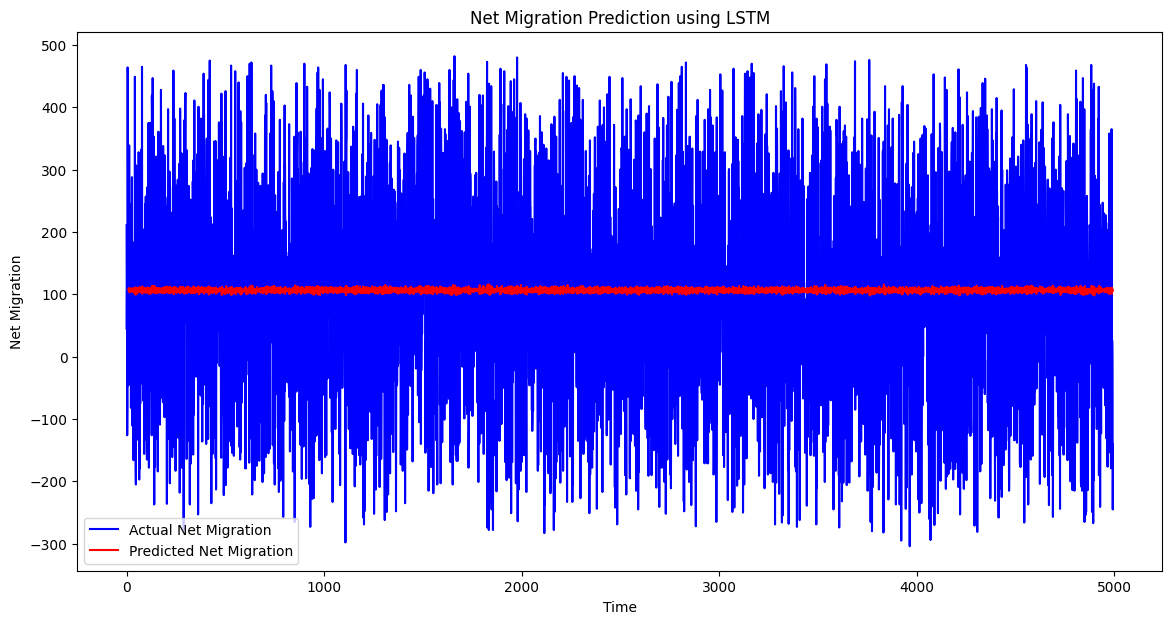

In [10]:
import matplotlib.pyplot as plt

# Inverse transform the actual values for comparison
actual_values = scaler.inverse_transform(data_scaled)

# Create a new figure
plt.figure(figsize=(14, 7))

# Plot actual values
plt.plot(actual_values, label='Actual Net Migration', color='blue')

# Plot predictions
plt.plot(np.arange(time_step, time_step + len(predictions)), predictions, label='Predicted Net Migration', color='red')

# Add titles and labels
plt.title('Net Migration Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Net Migration')
plt.legend()
plt.show()

In [23]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load your data
df = pd.read_csv("climate_migration_comprehensive_data.csv")

# Convert 'Date' to datetime and set it as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Split the data into training and testing sets
train_size = int(len(df) * 0.8)  # Use 80% of the data for training
train, test = df['Net_Migration'][:train_size], df['Net_Migration'][train_size:]

# Fit SARIMA model (p, d, q) x (P, D, Q, s)
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()

# Print the summary of the SARIMA model
print(results.summary())

# Make predictions on the test set
sarima_predictions = results.get_forecast(steps=len(test))
sarima_predictions = sarima_predictions.predicted_mean

# Calculate performance metrics
sarima_mae = mean_absolute_error(test, sarima_predictions)
sarima_mse = mean_squared_error(test, sarima_predictions)

print("SARIMA Model Performance:")
print("Mean Absolute Error:", sarima_mae)
print("Mean Squared Error:", sarima_mse)

C:\Users\tyeba\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\tyeba\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\tyeba\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\tyeba\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                      Net_Migration   No. Observations:                 3996
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -26049.431
Date:                            Fri, 29 Nov 2024   AIC                          52108.862
Time:                                    09:20:25   BIC                          52140.311
Sample:                                         0   HQIC                         52120.013
                                           - 3996                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0171      0.016      1.075      0.282      -0.014       0.048
ma.L1         -0.9998      0.005   

C:\Users\tyeba\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\tyeba\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [25]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load your data
df = pd.read_csv("climate_migration_comprehensive_data.csv")

# Define the dependent and independent variables
X = df[['Average_Temperature', 'Average_Precipitation', 'Population_Density']]
y = df['Net_Migration']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add a constant to the model (intercept)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the OLS model
model = sm.OLS(y_train, X_train).fit()

# Predict on the test set
ols_predictions = model.predict(X_test)

# Calculate performance metrics
ols_mae = mean_absolute_error(y_test, ols_predictions)
ols_mse = mean_squared_error(y_test, ols_predictions)

print("OLS Regression Performance:")
print("Mean Absolute Error:", ols_mae)
print("Mean Squared Error:", ols_mse)

OLS Regression Performance:
Mean Absolute Error: 133.62464286108474
Mean Squared Error: 26651.781468228706


In [27]:
# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Bayesian Ridge Regression Performance:")
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Bayesian Ridge Regression Performance:
Mean Squared Error: 26654.0390842746
R^2 Score: -0.000929223811791946


In [31]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming 'predictions' is already obtained from the LSTM model
# Inverse transform the predictions if necessary
predictions = scaler.inverse_transform(predictions)

# The target values for LSTM start from `time_step` to the end
Y_true = Y[time_step:]  # This should be your actual values

# Ensure predictions are aligned with Y_true
predictions = predictions[:len(Y_true)]  # Adjust predictions to match the length of Y_true

# Calculate performance metrics
lstm_mae = mean_absolute_error(Y_true, predictions)
lstm_mse = mean_squared_error(Y_true, predictions)

print("LSTM Model Performance:")
print("Mean Absolute Error:", lstm_mae)
print("Mean Squared Error:", lstm_mse)

LSTM Model Performance:
Mean Absolute Error: 83594.97176755994
Mean Squared Error: 6993182579.425621


In [33]:
print("Summary of Model Performance:")
print(f"SARIMA - MAE: {sarima_mae}, MSE: {sarima_mse}")
print(f"OLS - MAE: {ols_mae}, MSE: {ols_mse}")
print(f"Bayesian Ridge - MSE: {mse}, R^2: {r2}")
print(f"LSTM - MAE: {lstm_mae}, MSE: {lstm_mse}")

Summary of Model Performance:
SARIMA - MAE: 138.4389277579923, MSE: 28129.167478356863
OLS - MAE: 133.62464286108474, MSE: 26651.781468228706
Bayesian Ridge - MSE: 26654.0390842746, R^2: -0.000929223811791946
LSTM - MAE: 83594.97176755994, MSE: 6993182579.425621
